<a href="https://colab.research.google.com/github/haise-dev/SignatureClassification_ML2/blob/main/ml2_sig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/sig_dataset/

/content/drive/MyDrive/sig_dataset


In [ ]:
ls

CEDAR/


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, save_img
import matplotlib.pyplot as plt

def preprocess_and_save_images(input_dir, output_dir):
    """
    Preprocess and save images from input directory to output directory

    :param input_dir: Source directory with original images
    :param output_dir: Destination directory for preprocessed images
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get all image files
    image_files = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_files.append(os.path.join(root, file))

    print(f"Processing images from {input_dir}")
    print(f"Total images found: {len(image_files)}")

    # Process and save images
    processed_count = 0
    for img_path in image_files:
        try:
            # Read the image file
            img = tf.io.read_file(img_path)
            # Decode the image
            img = tf.image.decode_image(img, channels=3)
            # Resize to MobileNet input size
            img = tf.image.resize(img, [224, 224])
            # Normalize pixel values
            img = img / 255.0

            # Get original filename
            filename = os.path.basename(img_path)

            # Prepare output path
            output_path = os.path.join(output_dir, filename)

            # Save preprocessed image
            save_img(output_path, img.numpy())
            processed_count += 1
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    print(f"Successfully processed and saved {processed_count} images")

def main():
    # Base directory
    base_dir = '/content/drive/MyDrive/sig_dataset'

    # Input and output directories
    input_dirs = {
        'train': os.path.join(base_dir, 'CEDAR', 'train'),
        'val': os.path.join(base_dir, 'CEDAR', 'val'),
        'test': os.path.join(base_dir, 'CEDAR', 'test')
    }

    output_dirs = {
        'train': os.path.join(base_dir, 'CEDAR_preprocess', 'train'),
        'val': os.path.join(base_dir, 'CEDAR_preprocess', 'val'),
        'test': os.path.join(base_dir, 'CEDAR_preprocess', 'test')
    }

    # Process each dataset
    for split in ['train', 'val', 'test']:
        preprocess_and_save_images(input_dirs[split], output_dirs[split])

# Visualization function (optional)
def visualize_preprocessed_images(directory, num_samples=5):
    """
    Visualize random preprocessed images

    :param directory: Directory with preprocessed images
    :param num_samples: Number of sample images to display
    """
    # Get all image files
    image_files = [
        os.path.join(directory, f)
        for f in os.listdir(directory)
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
    ]

    # Randomly select images
    sample_images = np.random.choice(image_files, num_samples)

    # Create figure
    plt.figure(figsize=(15, 3*num_samples))

    for i, img_path in enumerate(sample_images):
        # Read and display image
        img = plt.imread(img_path)

        # Plot preprocessed image
        plt.subplot(num_samples, 2, i*2 + 1)
        plt.imshow(img)
        plt.title('Preprocessed Image')
        plt.axis('off')

        # Display filename information
        plt.subplot(num_samples, 2, i*2 + 2)
        filename = os.path.basename(img_path)
        plt.text(0.5, 0.5,
                 f"Filename: {filename}",
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('preprocessed_images_sample.png')
    plt.close()

# Uncomment to run
main()
visualize_preprocessed_images('/content/drive/MyDrive/sig_dataset/CEDAR_preprocess/train')

Processing images from /content/drive/MyDrive/sig_dataset/CEDAR/train
Total images found: 960
Successfully processed and saved 960 images
Processing images from /content/drive/MyDrive/sig_dataset/CEDAR/val
Total images found: 240
Successfully processed and saved 240 images
Processing images from /content/drive/MyDrive/sig_dataset/CEDAR/test
Total images found: 240
Successfully processed and saved 240 images


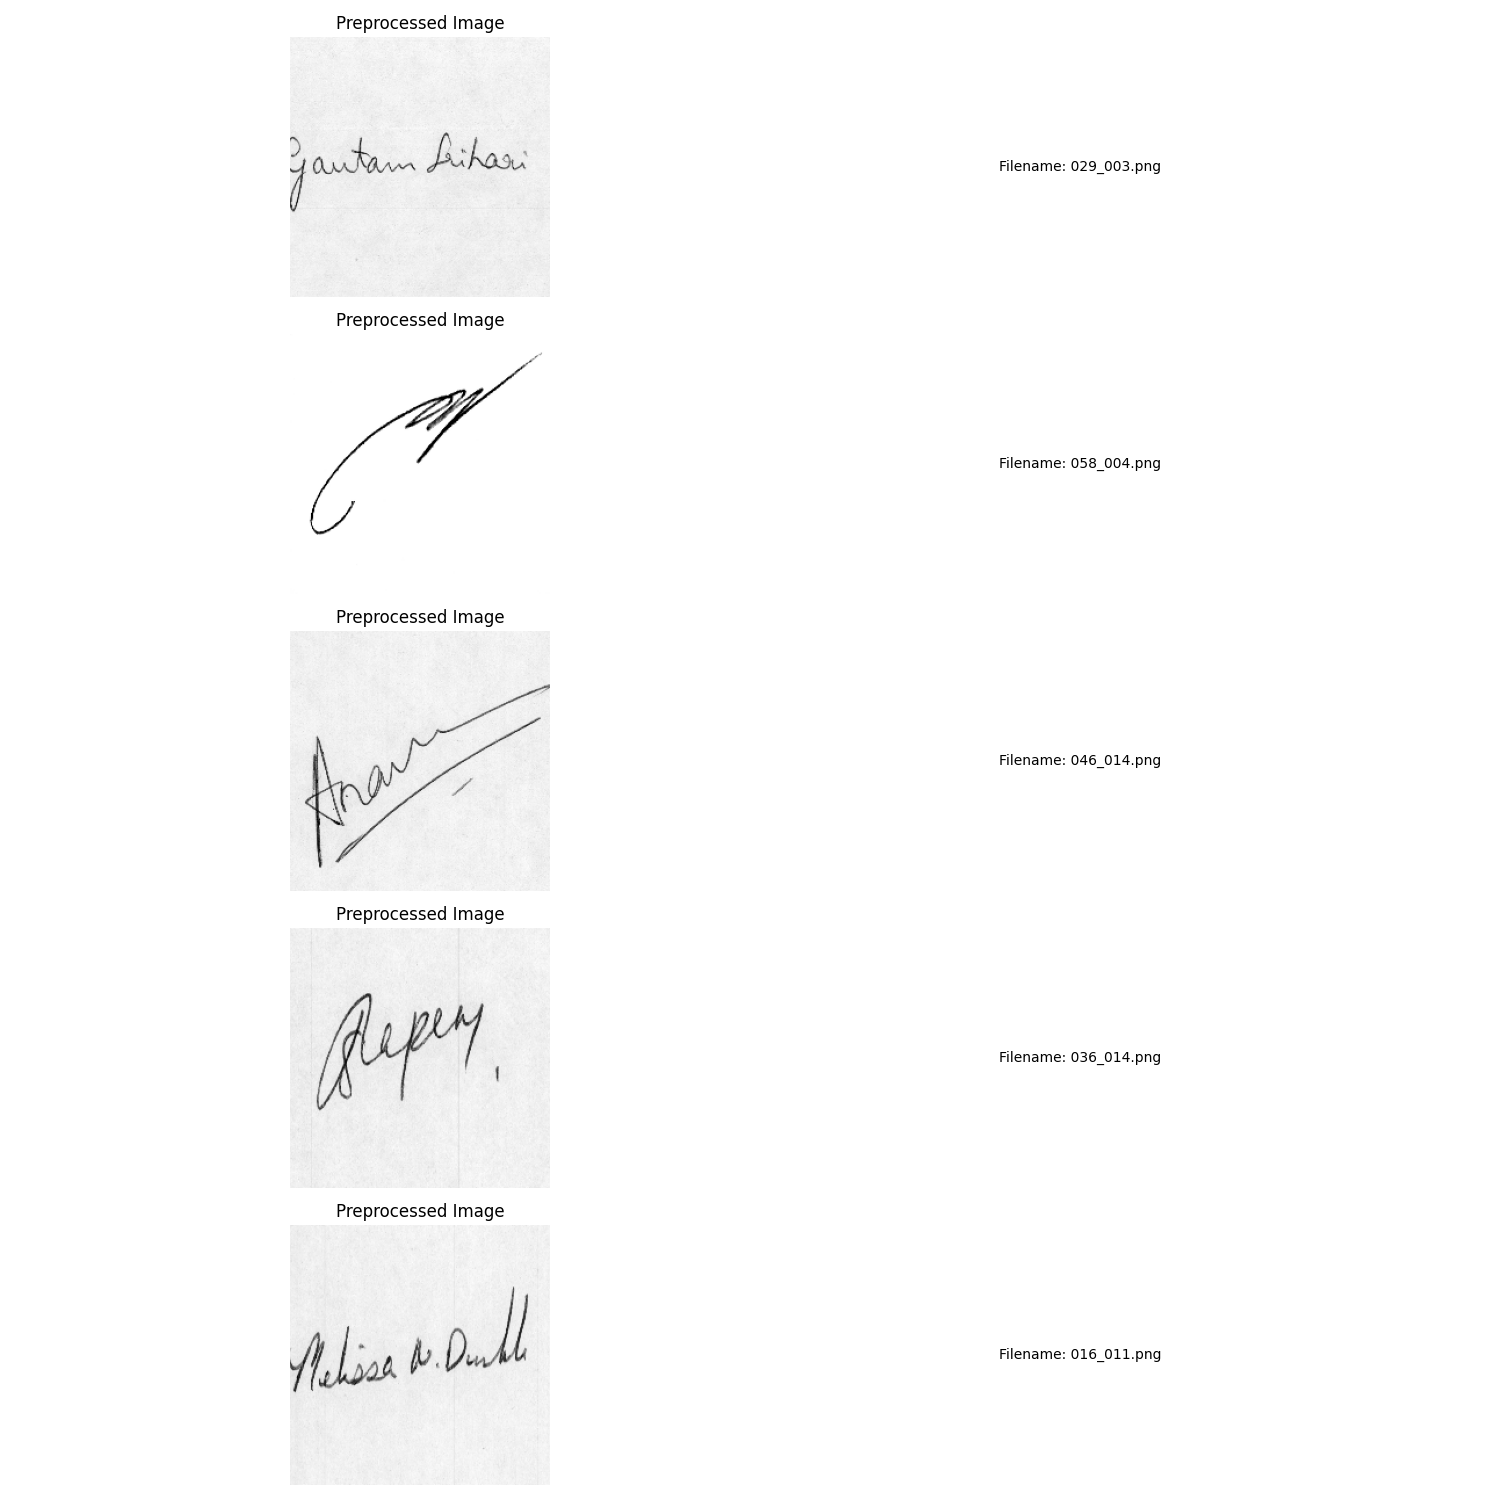

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

# doc anh va hien thi
img_path = '/content/drive/MyDrive/sig_dataset/preprocessed_images_sample.png'
img = cv2.imread(img_path)
cv2_imshow(img)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def load_dataset(directory):
    """
    Load images and labels from directory

    :param directory: Path to directory containing images
    :return: Images, labels, and filenames
    """
    images = []
    labels = []
    filenames = []

    # Extract unique person IDs from filenames
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Get unique person IDs
    unique_persons = sorted(set(f.split('_')[0] for f in image_files))

    # Create a mapping of person ID to class index
    class_to_index = {person: idx for idx, person in enumerate(unique_persons)}

    # Process images
    for img_name in image_files:
        img_path = os.path.join(directory, img_name)

        # Load and preprocess image
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0

        # Extract person ID and convert to class index
        person_id = img_name.split('_')[0]

        images.append(img_array)
        labels.append(class_to_index[person_id])
        filenames.append(img_name)

    return (np.array(images),
            tf.keras.utils.to_categorical(labels, num_classes=len(unique_persons)),
            filenames,
            class_to_index)

def create_mobilenet_model(num_classes, input_shape=(224, 224, 3)):
    """
    Create a MobileNetV2 model for signature classification

    :param num_classes: Number of signature classes
    :param input_shape: Input image shape
    :return: Compiled Keras model
    """
    # Base MobileNetV2 model
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model layers for transfer learning
    base_model.trainable = False

    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_and_evaluate_model(train_dir, val_dir, test_dir):
    """
    Train and evaluate the signature classification model

    :param train_dir: Directory with training images
    :param val_dir: Directory with validation images
    :param test_dir: Directory with test images
    :return: Trained model and evaluation metrics
    """
    # Load datasets
    X_train, y_train, train_filenames, class_to_index = load_dataset(train_dir)
    X_val, y_val, val_filenames, _ = load_dataset(val_dir)
    X_test, y_test, test_filenames, _ = load_dataset(test_dir)

    # Create model
    num_classes = y_train.shape[1]
    model = create_mobilenet_model(num_classes)

    # Callbacks
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    )

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_signature_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[reduce_lr, early_stopping, model_checkpoint]
    )

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    # Predictions for detailed metrics
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Mapping class indices back to original person IDs
    index_to_class = {v: k for k, v in class_to_index.items()}

    # Classification report
    class_report = classification_report(
        y_true_classes,
        y_pred_classes,
        target_names=[index_to_class[cls] for cls in range(num_classes)]
    )

    # Confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Visualization functions
    def plot_training_history():
        plt.figure(figsize=(12,4))

        plt.subplot(1,2,1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.close()

    def plot_confusion_matrix():
        plt.figure(figsize=(10,8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.close()

    # Generate visualizations
    plot_training_history()
    plot_confusion_matrix()

    # Function to predict and explain a random test image
    def predict_random_test_image():
        # Choose a random test image
        random_index = np.random.randint(len(X_test))
        test_image = X_test[random_index]
        true_label = index_to_class[y_true_classes[random_index]]
        predicted_label = index_to_class[y_pred_classes[random_index]]

        # Visualize the image and prediction
        plt.figure(figsize=(6,4))
        plt.imshow(test_image)
        plt.title(f'True Label: {true_label}, Predicted: {predicted_label}')
        plt.axis('off')
        plt.savefig('random_test_prediction.png')
        plt.close()

        return {
            'true_label': true_label,
            'predicted_label': predicted_label,
            'filename': test_filenames[random_index]
        }

    # Predict a random test image
    random_prediction = predict_random_test_image()

    # Print detailed results
    print("\n--- Model Evaluation Results ---")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print("\nClassification Report:")
    print(class_report)

    return {
        'model': model,
        'test_accuracy': test_accuracy,
        'classification_report': class_report,
        'confusion_matrix': cm,
        'random_prediction': random_prediction
    }

# Main execution
def main():
    # Paths to preprocessed datasets
    base_dir = '/content/drive/MyDrive/sig_dataset/CEDAR_preprocess'
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    test_dir = os.path.join(base_dir, 'test')

    # Train and evaluate the model
    results = train_and_evaluate_model(train_dir, val_dir, test_dir)

    return results

results = main()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0315 - loss: 4.3969

30/30 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.0324 - loss: 4.3872 - val_accuracy: 0.4375 - val_loss: 3.1798 - learning_rate: 1.0000e-04
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2470 - loss: 3.1551

30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.2490 - loss: 3.1502 - val_accuracy: 0.8083 - val_loss: 2.3497 - learning_rate: 1.0000e-04
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5439 - loss: 2.3035

30/30 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5443 - loss: 2.3002 - val_accuracy: 0.9208 - val_loss: 1.6768 - learning_rate: 1.0000e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6924 - loss: 1.7592

30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6933 - loss: 1.7552 - val_accuracy: 0.9833 - val_loss: 1.1734 - learning_rate: 1.0000e-04
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7842 - loss: 1.2869

30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7851 - loss: 1.2840 - val_accuracy: 0.9958 - val_loss: 0.8492 - learning_rate: 1.0000e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8824 - loss: 0.9500 - val_accuracy: 0.9958 - val_loss: 0.6249 - learning_rate: 1.0000e-04
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9287 - loss: 0.7027 - val_accuracy: 0.9958 - val_loss: 0.4729 - learning_rate: 1.0000e-04
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9311 - loss: 0.6030 - val_accuracy: 0.9958 - val_loss: 0.3705 - learning_rate: 1.0000e-04
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9580 - loss: 0.4706 - val_accuracy: 0.9958 - val_loss: 0.2984 - learning_rate: 1.0000e-04
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9667 - loss: 0.3580 - val_accuracy: 0.9958 - val_loss: 0.2539 - learning_rate: 1.0000e-04
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9771 - loss: 0.2948 -

Các chỉ số đáng chú ý:

Accuracy tổng thể: 97.92%
Macro avg precision, recall, f1-score: 0.98
Mỗi lớp (person) đều có 4 mẫu trong tập test

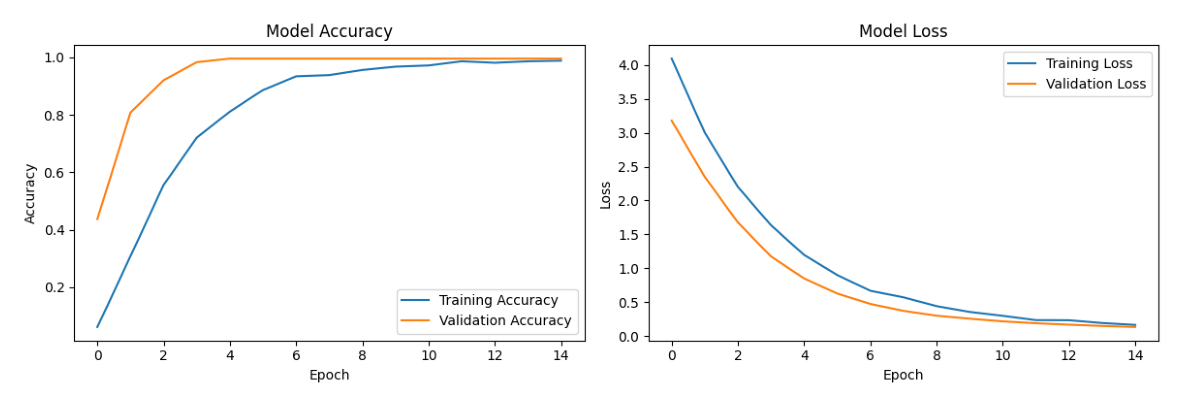

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

#hiển thị biểu đồ quá trình huấn luyện
img = mpimg.imread('/content/drive/MyDrive/sig_dataset/training_history.png')
plt.figure(figsize=(15,10))
plt.imshow(img)
plt.axis('off')
plt.show()

Training History:

Biểu đồ bên trái: Accuracy của tập train và validation
Biểu đồ bên phải: Loss của tập train và validation

Nôm na là quá trình học của mô hình

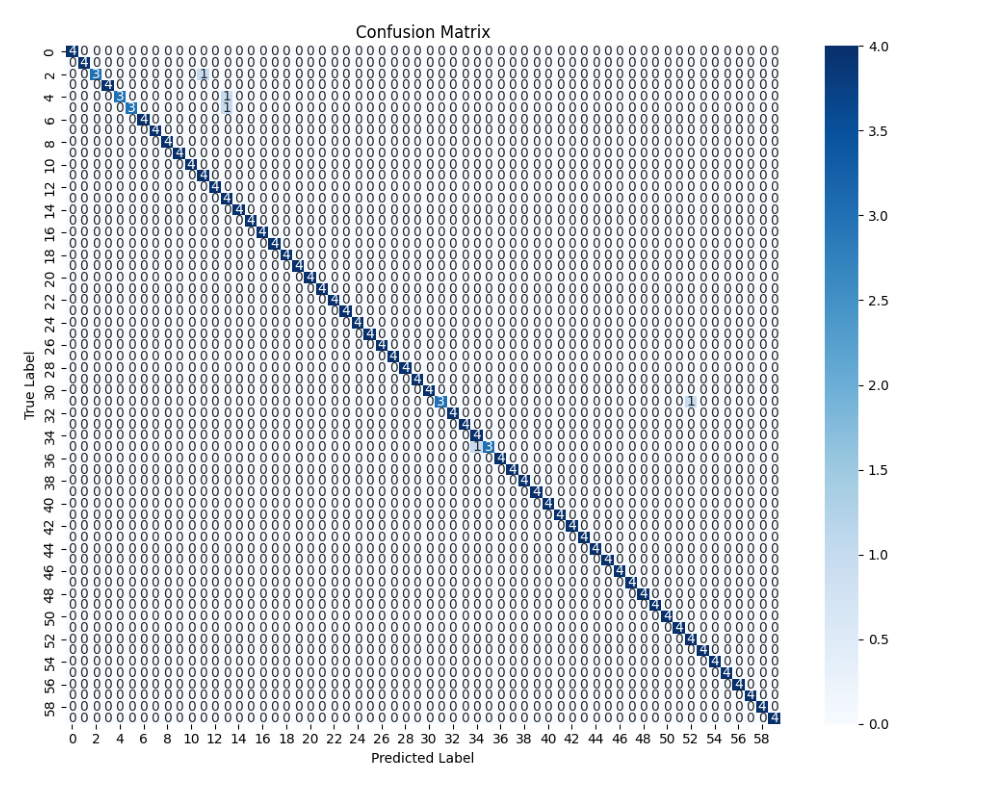

In [ ]:
img = mpimg.imread('/content/drive/MyDrive/sig_dataset/confusion_matrix.png')
plt.figure(figsize=(15,10))
plt.imshow(img)
plt.axis('off')
plt.show()

Confusion Matrix:

Thể hiện số lượng dự đoán đúng/sai giữa các lớp
Các ô đường chéo màu xanh là các dự đoán đúng
Độ sáng màu biểu thị số lượng dự đoán


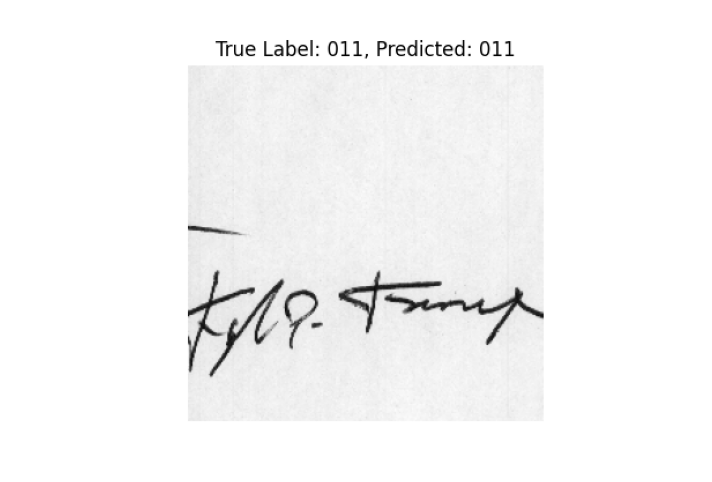

In [ ]:
img = mpimg.imread('/content/drive/MyDrive/sig_dataset/random_test_prediction.png')
plt.figure(figsize=(10,6))
plt.imshow(img)
plt.axis('off')
plt.show()

Random Test Prediction:

Hiển thị một ảnh ngẫu nhiên từ tập test
So sánh nhãn thực tế và nhãn dự đoán


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


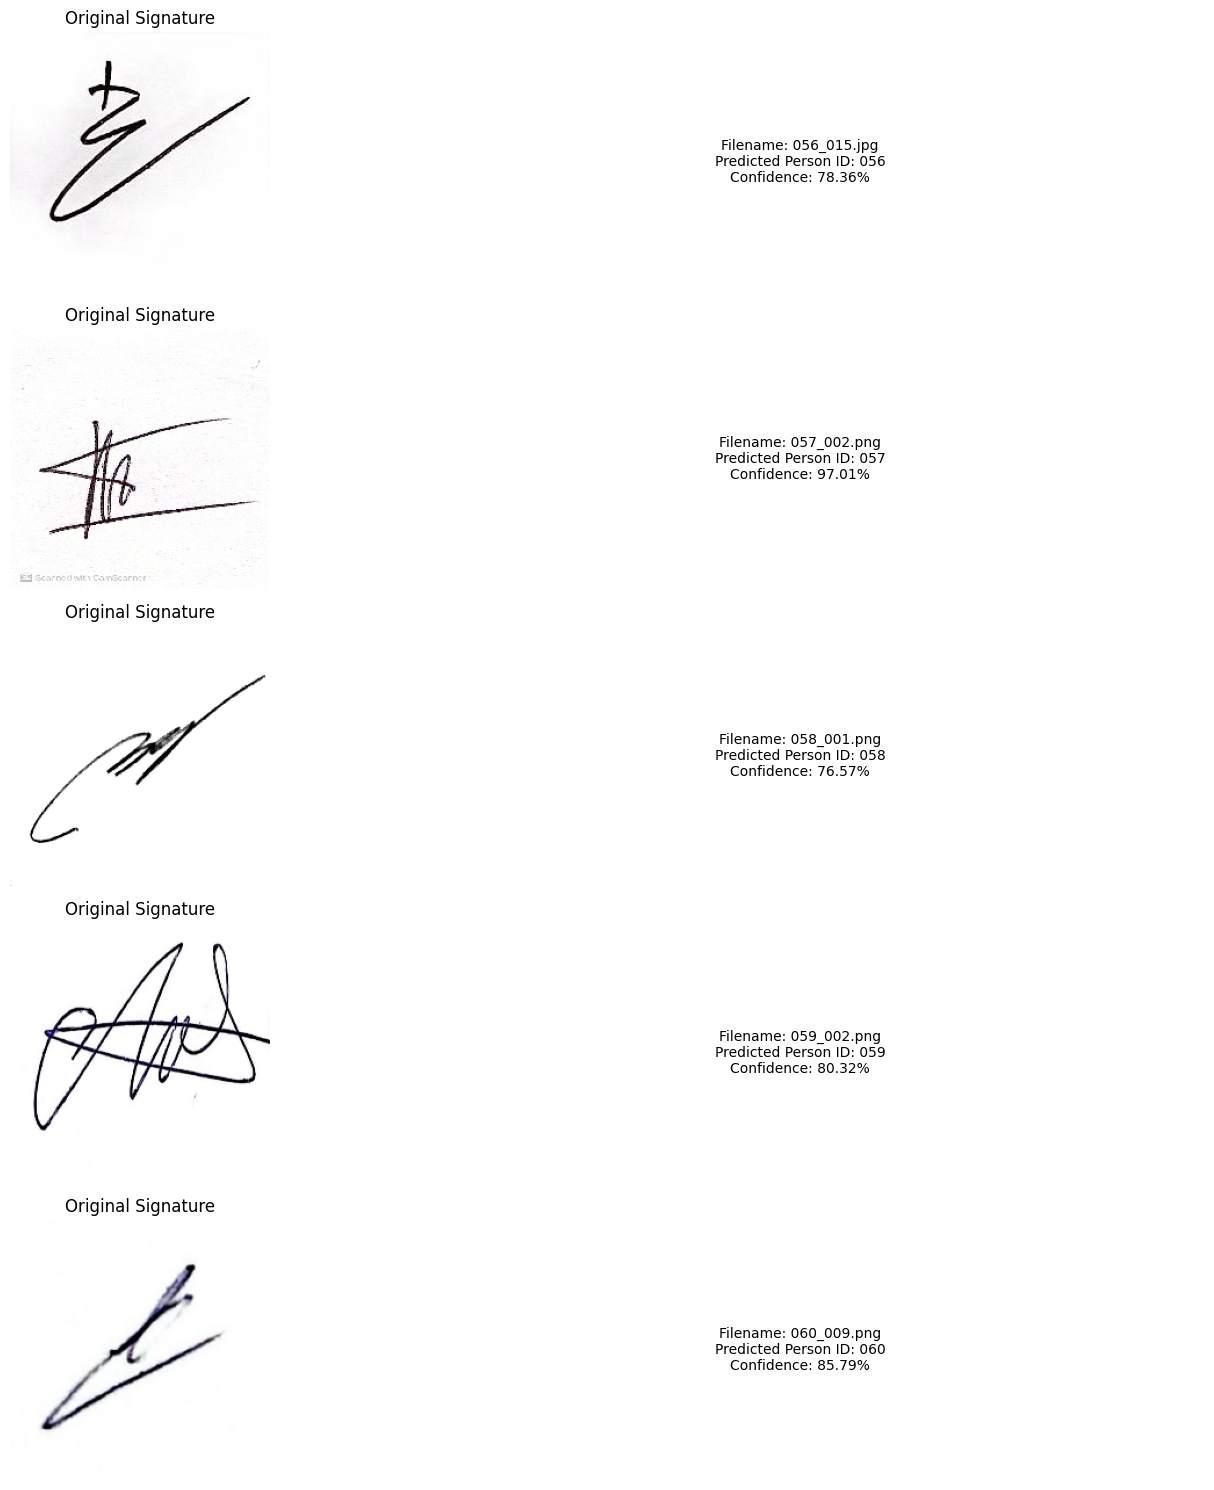

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

def predict_signature(model, image_path):
    """
    Predict the signature owner

    :param model: Trained Keras model
    :param image_path: Path to the signature image
    :return: Prediction details
    """
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions) * 100

    return {
        'predicted_person_id': f'{predicted_class + 1:03d}',
        'confidence': confidence
    }

def visualize_signatures(model, image_paths):
    """
    Visualize signature images with predictions

    :param model: Trained Keras model
    :param image_paths: List of image paths to predict
    """
    plt.figure(figsize=(15, 3*len(image_paths)))

    for i, image_path in enumerate(image_paths):
        # Load image
        img = plt.imread(image_path)

        # Predict
        prediction = predict_signature(model, image_path)

        # Plot image
        plt.subplot(len(image_paths), 2, i*2 + 1)
        plt.imshow(img)
        plt.title(f'Original Signature')
        plt.axis('off')

        # Plot prediction details
        plt.subplot(len(image_paths), 2, i*2 + 2)
        plt.text(0.5, 0.5,
                 f"Filename: {os.path.basename(image_path)}\n"
                 f"Predicted Person ID: {prediction['predicted_person_id']}\n"
                 f"Confidence: {prediction['confidence']:.2f}%",
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('signature_predictions.png')
    plt.show()

# Main execution
def main():
    # Load the trained model
    model = tf.keras.models.load_model('best_signature_model.h5')

    # List of signature images to test
    test_signatures = [
        '/content/drive/MyDrive/sig_dataset/CEDAR_preprocess/test/056_015.jpg',
        '/content/drive/MyDrive/sig_dataset/CEDAR_preprocess/test/057_002.png',
        '/content/drive/MyDrive/sig_dataset/CEDAR_preprocess/test/058_001.png',
        '/content/drive/MyDrive/sig_dataset/CEDAR_preprocess/test/059_002.png',
        '/content/drive/MyDrive/sig_dataset/CEDAR_preprocess/test/060_009.png'
    ]

    # Visualize predictions
    visualize_signatures(model, test_signatures)
main()

Test chữ ký thành viên trong nhóm

In [ ]:
!find /content/drive -name "best_signature_model.h5"

/content/drive/MyDrive/sig_dataset/best_signature_model.h5


Kích thước input của model: 224x224
Tìm thấy 240 file ảnh trong thư mục test.
Tìm thấy 60 ID người dùng duy nhất.
Đang xử lý ảnh...


100%|██████████| 240/240 [00:06<00:00, 36.68it/s]


Đã tải thành công 240 ảnh từ 60 class.
Số lượng classes (ID người dùng): 60
Đang thực hiện dự đoán...
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Accuracy: 0.9792
Precision: 0.9844
Recall: 0.9792
F1-Score: 0.9792

Classification Report:
              precision    recall  f1-score     support
001            1.000000  1.000000  1.000000    4.000000
002            1.000000  1.000000  1.000000    4.000000
003            1.000000  0.750000  0.857143    4.000000
004            1.000000  1.000000  1.000000    4.000000
005            1.000000  0.750000  0.857143    4.000000
...                 ...       ...       ...         ...
059            1.000000  1.000000  1.000000    4.000000
060            1.000000  1.000000  1.000000    4.000000
accuracy       0.979167  0.979167  0.979167    0.979167
macro avg      0.984444  0.979167  0.979206  240.000000
weighted avg   0.984444  0.979167  0.979206  240.000000

[63 rows x 4 columns]


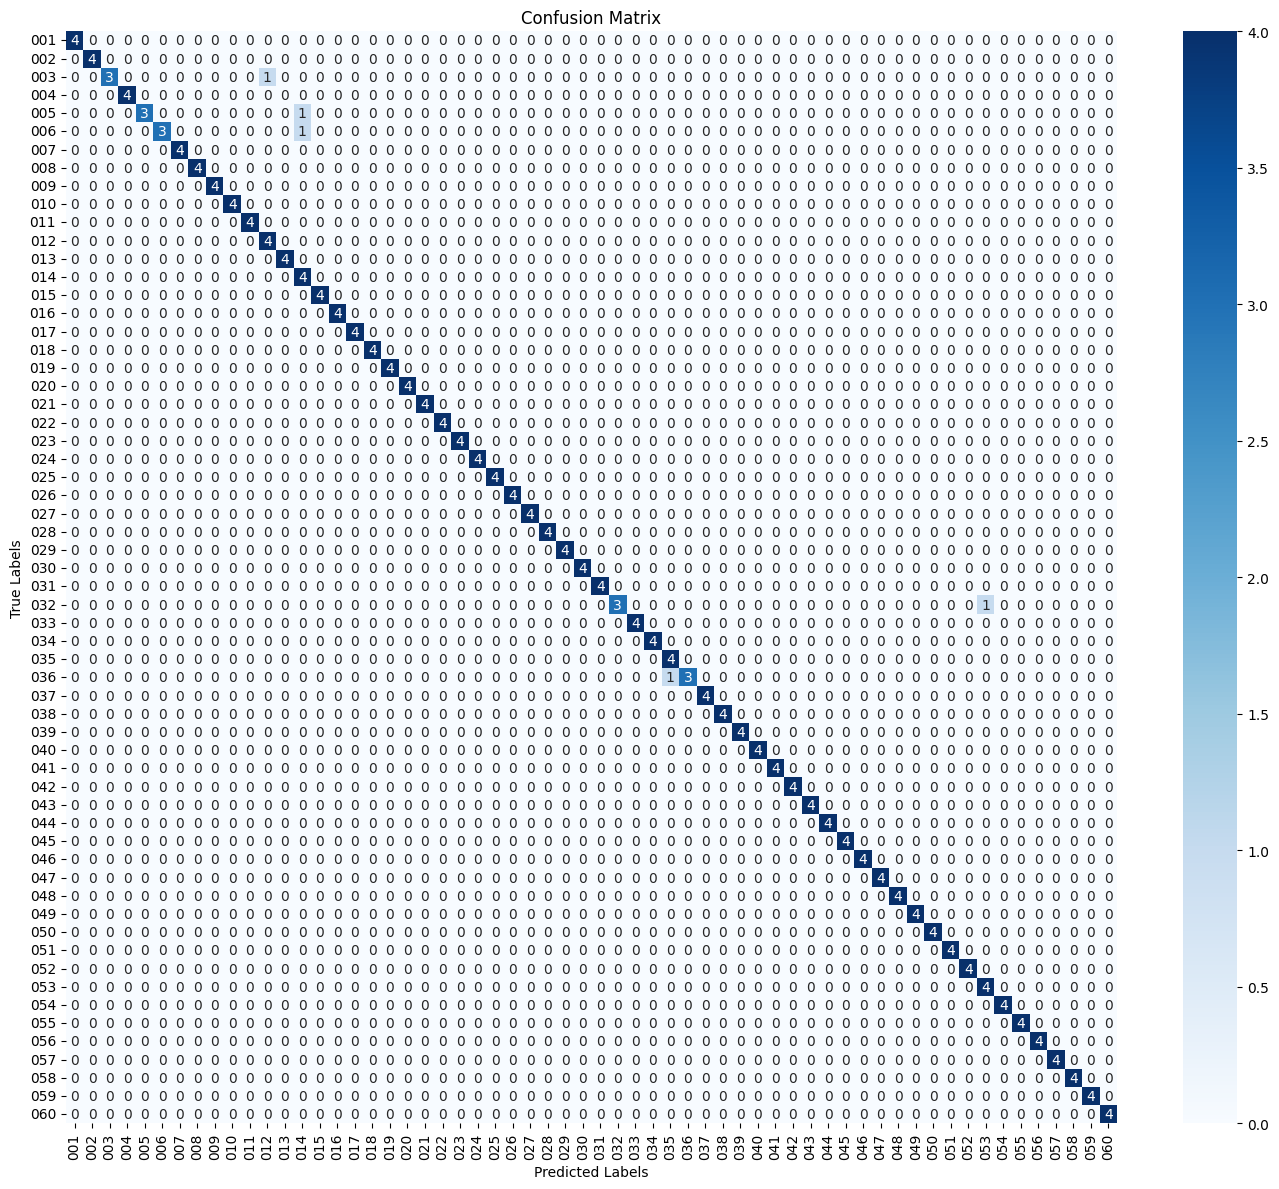

<ipython-input-5-33abd273b27d>:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Class', data=class_accuracy_df, palette='viridis')


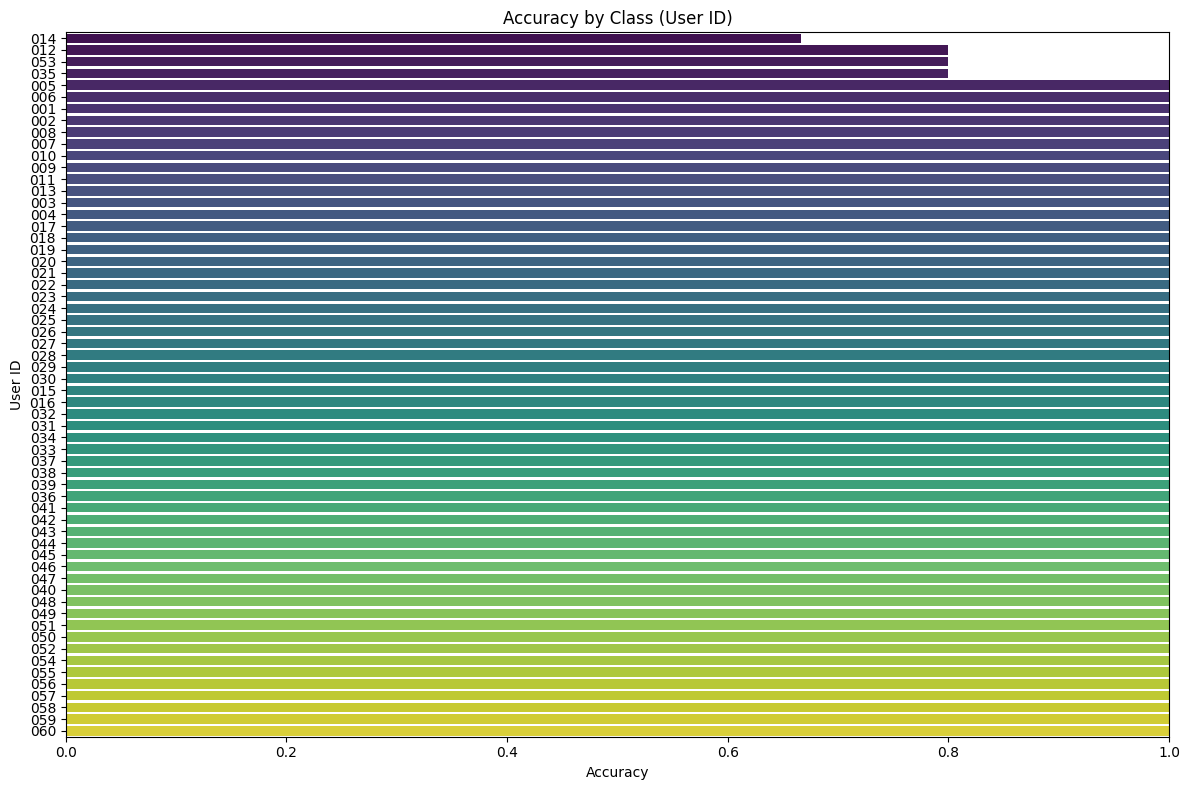

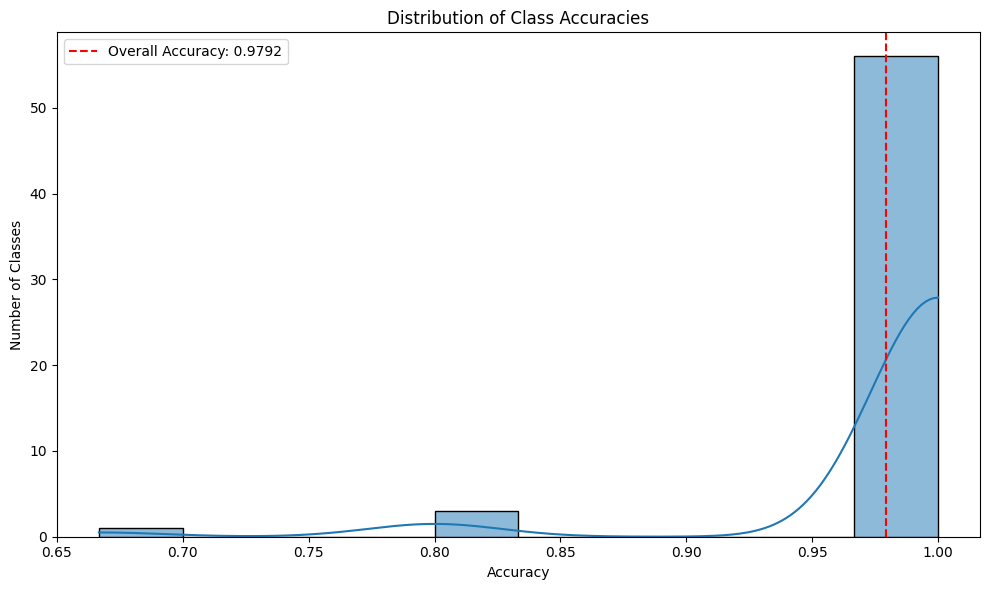

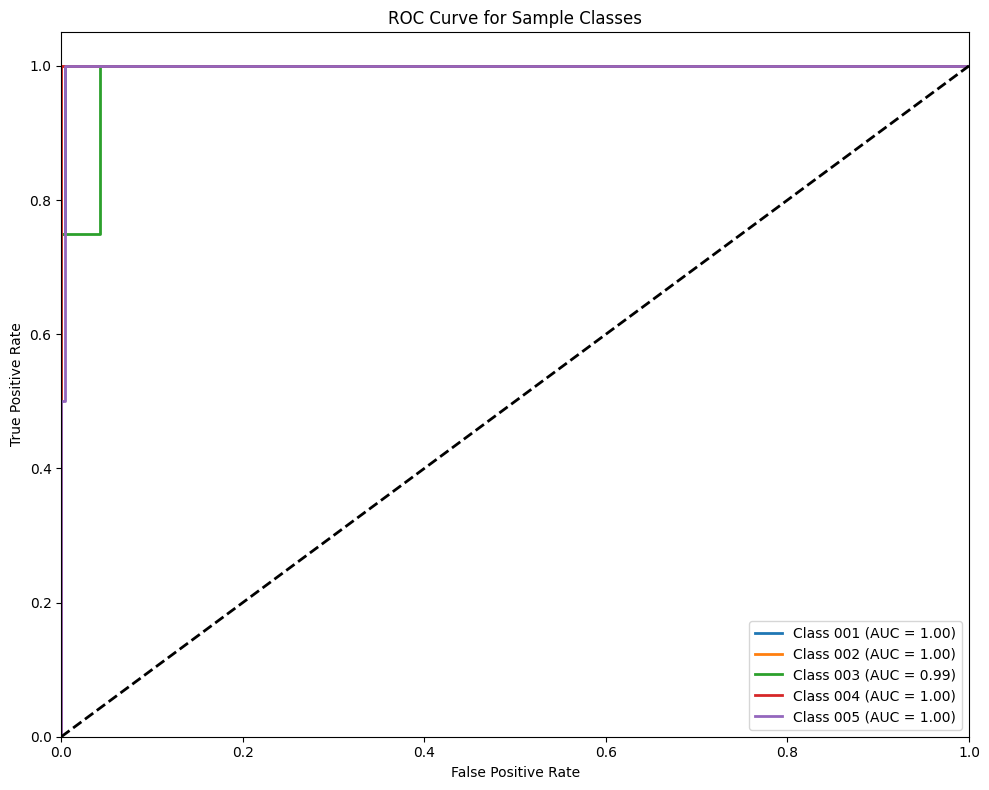


Tổng số dự đoán sai: 5 trên tổng số 240 ảnh test
Tỷ lệ lỗi: 2.08%


<ipython-input-5-33abd273b27d>:229: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Error Count', data=error_by_true.head(top_n), palette='Reds')


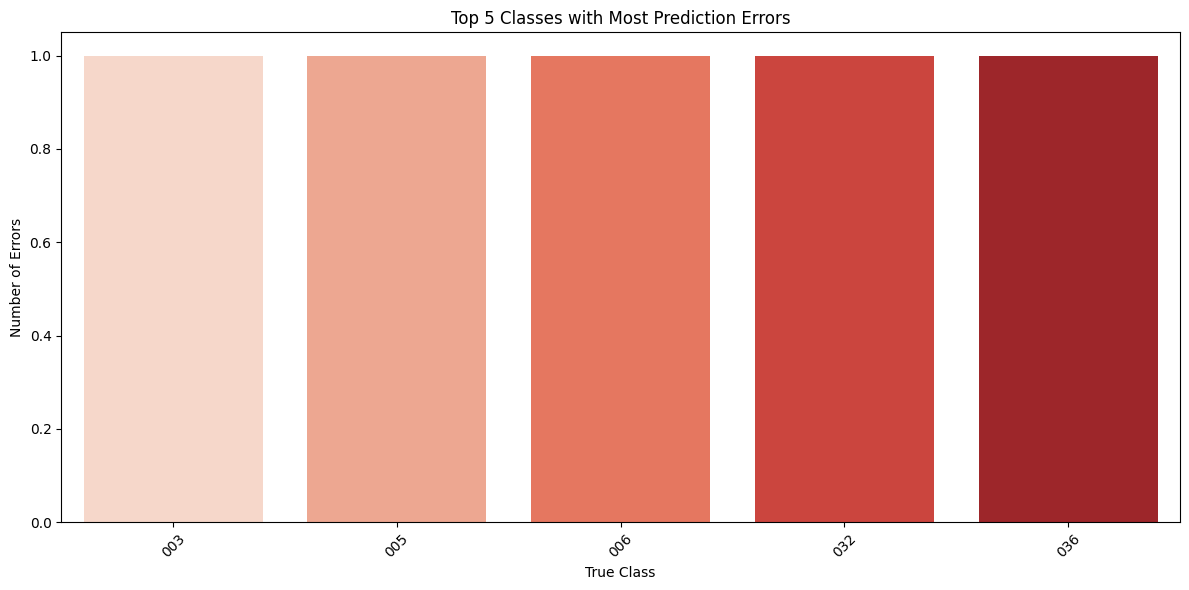

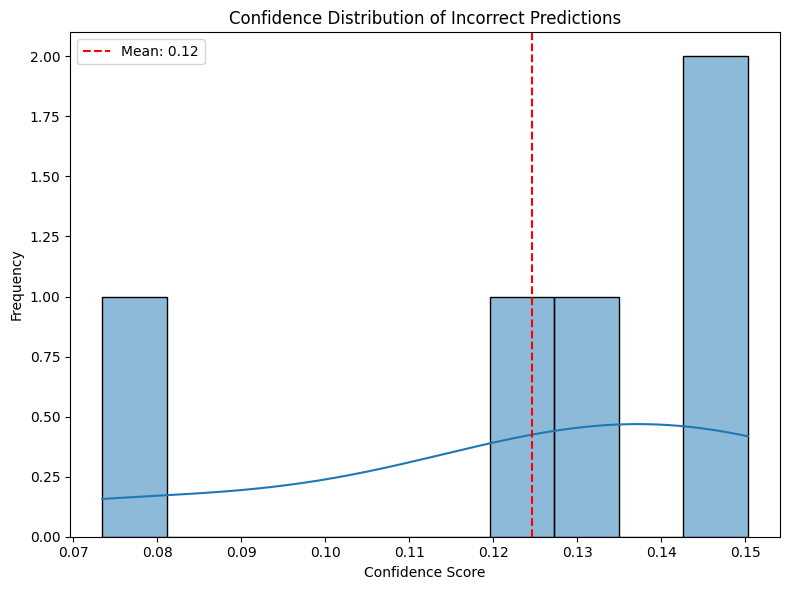

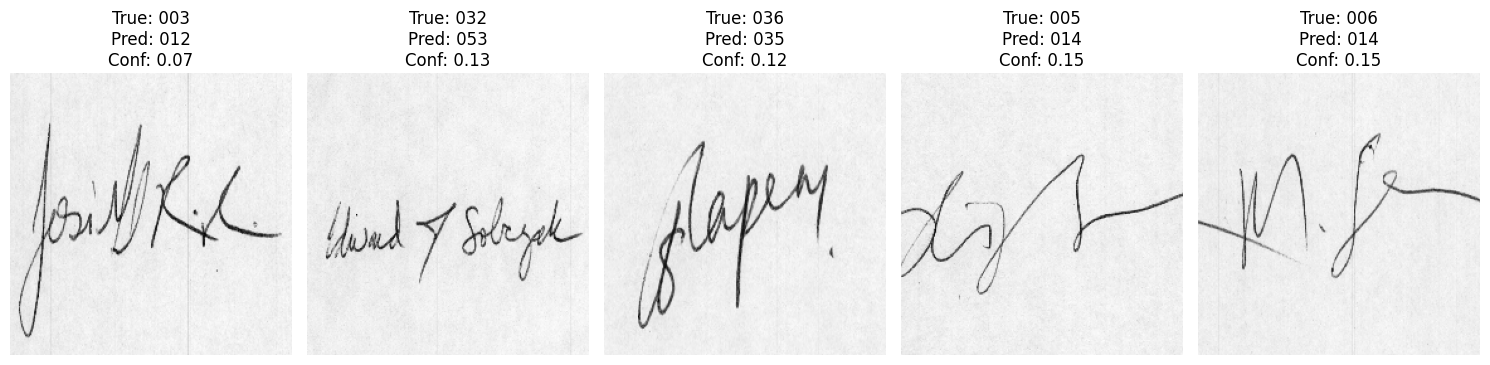

<ipython-input-5-33abd273b27d>:291: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


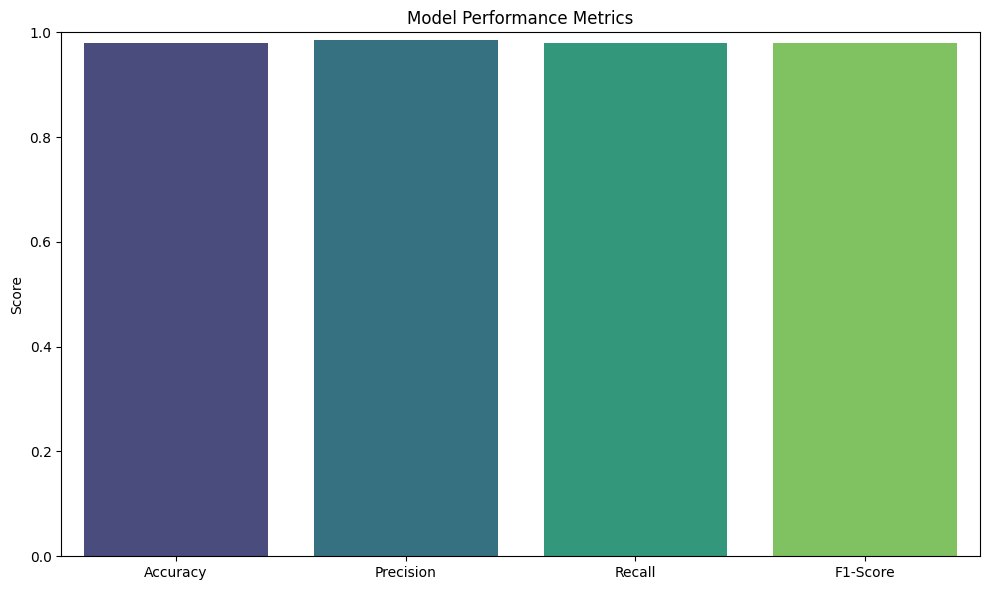


Summary of Model Performance:
      Metric     Value
0   Accuracy  0.979167
1  Precision  0.984444
2     Recall  0.979167
3   F1-Score  0.979206


<ipython-input-5-33abd273b27d>:318: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sample Count', y='Class', data=class_counts_df, palette='viridis')


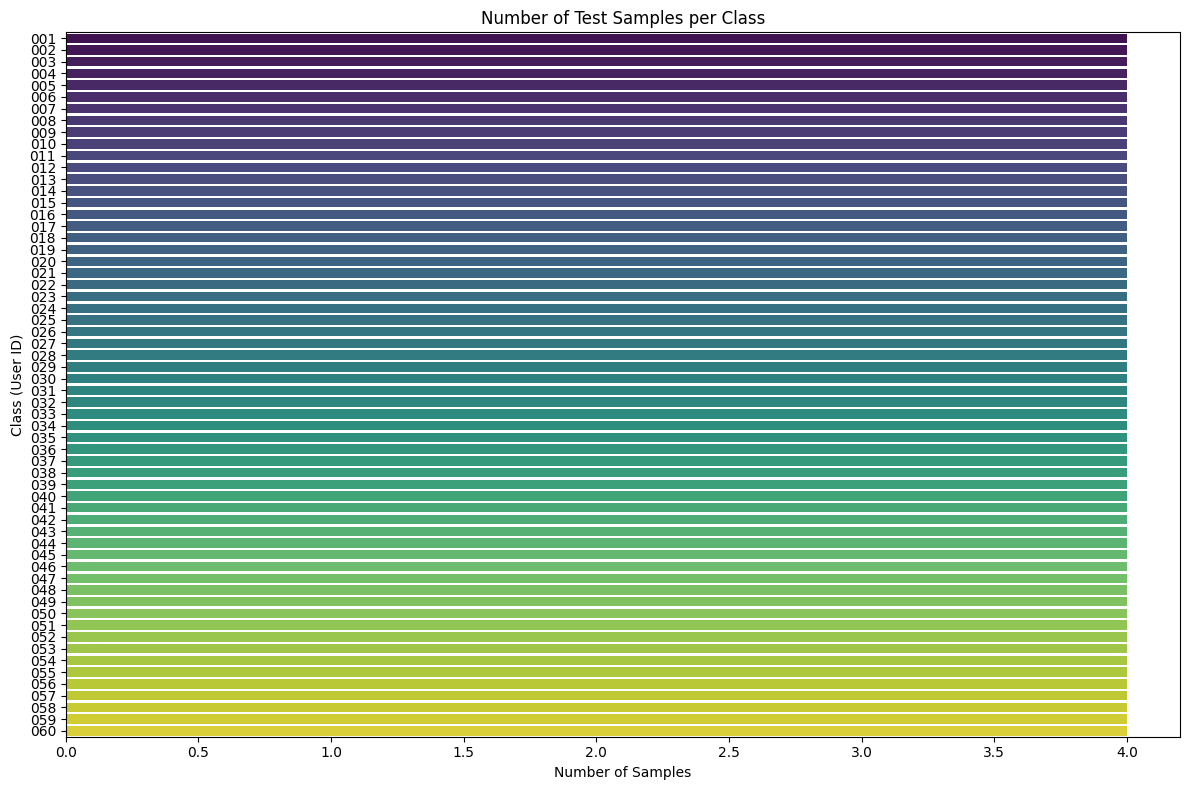


Quá trình đánh giá model đã hoàn tất. Các file biểu đồ và báo cáo đã được lưu.


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
from tqdm import tqdm
import re

# Đường dẫn đến tập test
test_dir = '/content/drive/MyDrive/sig_dataset/CEDAR_preprocess/test'

# Load model đã huấn luyện
model = tf.keras.models.load_model('/content/drive/MyDrive/sig_dataset/best_signature_model.h5')

# Kích thước ảnh đầu vào từ model
input_shape = model.input_shape[1:3]
img_height, img_width = input_shape[0], input_shape[1]
print(f"Kích thước input của model: {img_height}x{img_width}")

# Hàm để trích xuất ID người dùng từ tên file
def extract_user_id(filename):
    # Dựa vào mẫu tên file 001_004.png, lấy phần đầu làm ID
    match = re.match(r'(\d+)_', os.path.basename(filename))
    if match:
        return match.group(1)
    return None

# Hàm để lấy dữ liệu test từ cấu trúc phẳng (không có thư mục con)
def load_test_data_flat(test_dir, img_height, img_width):
    images = []
    labels = []
    true_filenames = []
    user_ids = []

    # Lấy tất cả các file ảnh trong thư mục test
    image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Tìm thấy {len(image_files)} file ảnh trong thư mục test.")

    # Trích xuất ID người dùng từ tên file
    for filename in image_files:
        user_id = extract_user_id(filename)
        if user_id:
            user_ids.append(user_id)

    # Lấy danh sách các ID người dùng duy nhất và sắp xếp
    unique_user_ids = sorted(list(set(user_ids)))
    print(f"Tìm thấy {len(unique_user_ids)} ID người dùng duy nhất.")

    # Dictionary để ánh xạ ID người dùng thành nhãn số
    user_id_to_label = {user_id: i for i, user_id in enumerate(unique_user_ids)}

    # Xử lý từng file ảnh
    print("Đang xử lý ảnh...")
    for filename in tqdm(image_files):
        user_id = extract_user_id(filename)
        if not user_id:
            print(f"Bỏ qua file {filename}: không trích xuất được ID người dùng.")
            continue

        img_path = os.path.join(test_dir, filename)
        try:
            # Đọc và tiền xử lý ảnh
            img = load_img(img_path, target_size=(img_height, img_width))
            img_array = img_to_array(img)
            img_array = img_array / 255.0  # Chuẩn hóa

            images.append(img_array)
            labels.append(user_id_to_label[user_id])  # Chuyển ID người dùng thành nhãn số
            true_filenames.append(img_path)
        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {img_path}: {str(e)}")

    if not images:
        raise ValueError(f"Không tìm thấy ảnh hợp lệ nào trong thư mục test: {test_dir}")

    return np.array(images), np.array(labels), true_filenames, unique_user_ids

# Tải dữ liệu test với xử lý lỗi
try:
    X_test, y_test, test_filenames, class_names = load_test_data_flat(test_dir, img_height, img_width)
    print(f"Đã tải thành công {len(X_test)} ảnh từ {len(class_names)} class.")

    # Kiểm tra xem số lượng ảnh có phù hợp không
    if len(X_test) == 0:
        raise ValueError("Không tìm thấy ảnh nào để đánh giá.")

    # Kiểm tra số lượng classes
    print(f"Số lượng classes (ID người dùng): {len(class_names)}")

    # Kiểm tra xem model có đúng số lượng đầu ra không
    if model.output_shape[1] != len(class_names):
        print(f"Cảnh báo: Số lượng đầu ra của model ({model.output_shape[1]}) khác với số lượng classes ({len(class_names)})")
        print("Sẽ chỉ dự đoán các classes tương ứng với classes khi huấn luyện.")

    # Dự đoán trên tập test
    print("Đang thực hiện dự đoán...")
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Kiểm tra xem các dự đoán có nằm trong phạm vi hợp lệ không
    valid_y_pred = y_pred < len(class_names)
    if not all(valid_y_pred):
        print(f"Cảnh báo: Có {np.sum(~valid_y_pred)} dự đoán không hợp lệ. Chỉ đánh giá trên các dự đoán hợp lệ.")
        valid_indices = np.where(valid_y_pred)[0]
        X_test = X_test[valid_indices]
        y_test = y_test[valid_indices]
        y_pred = y_pred[valid_indices]
        y_pred_prob = y_pred_prob[valid_indices]
        test_filenames = [test_filenames[i] for i in valid_indices]

    # Tính các metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # In chi tiết classification report
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)

    # Lưu report dưới dạng CSV để dễ tham khảo
    report_df.to_csv('classification_report.csv')

    # 1. Vẽ Confusion Matrix
    plt.figure(figsize=(14, 12))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Vẽ biểu đồ độ chính xác cho từng class
    plt.figure(figsize=(12, 8))
    class_accuracy = report_df.loc[class_names, 'precision'].values
    class_accuracy_df = pd.DataFrame({'Class': class_names, 'Accuracy': class_accuracy})
    class_accuracy_df = class_accuracy_df.sort_values('Accuracy')

    sns.barplot(x='Accuracy', y='Class', data=class_accuracy_df, palette='viridis')
    plt.title('Accuracy by Class (User ID)')
    plt.xlabel('Accuracy')
    plt.ylabel('User ID')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.savefig('class_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Histogram của độ chính xác các class
    plt.figure(figsize=(10, 6))
    sns.histplot(class_accuracy, bins=10, kde=True)
    plt.axvline(accuracy, color='red', linestyle='--', label=f'Overall Accuracy: {accuracy:.4f}')
    plt.title('Distribution of Class Accuracies')
    plt.xlabel('Accuracy')
    plt.ylabel('Number of Classes')
    plt.legend()
    plt.tight_layout()
    plt.savefig('accuracy_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Vẽ ROC Curve (One-vs-Rest) cho một số class (lấy 5 class đầu tiên để biểu diễn)
    # Binarize nhãn cho ROC curve
    n_classes = len(class_names)
    sample_classes = min(5, n_classes)  # Lấy 5 class hoặc ít hơn nếu có ít class

    if n_classes > 1:  # Chỉ vẽ ROC curve nếu có nhiều hơn 1 class
        y_test_bin = label_binarize(y_test, classes=range(n_classes))

        plt.figure(figsize=(10, 8))

        for i in range(sample_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Sample Classes')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
        plt.show()

    # 5. Phân tích các dự đoán sai
    incorrect_predictions = []
    for i in range(len(y_test)):
        if y_pred[i] != y_test[i]:
            file_name = os.path.basename(test_filenames[i])
            incorrect_predictions.append({
                'filename': file_name,
                'true_label': class_names[y_test[i]],
                'predicted_label': class_names[y_pred[i]],
                'confidence': y_pred_prob[i][y_pred[i]]
            })

    incorrect_df = pd.DataFrame(incorrect_predictions)
    print(f"\nTổng số dự đoán sai: {len(incorrect_predictions)} trên tổng số {len(y_test)} ảnh test")
    print(f"Tỷ lệ lỗi: {len(incorrect_predictions)/len(y_test):.2%}")

    if len(incorrect_predictions) > 0:
        # Lưu thông tin các dự đoán sai để phân tích thêm
        incorrect_df.to_csv('incorrect_predictions.csv', index=False)

        # Biểu đồ các lỗi dự đoán theo class thật
        plt.figure(figsize=(12, 6))
        error_by_true = incorrect_df.groupby('true_label').size().reset_index()
        error_by_true.columns = ['Class', 'Error Count']
        error_by_true = error_by_true.sort_values('Error Count', ascending=False)

        top_n = min(10, len(error_by_true))
        sns.barplot(x='Class', y='Error Count', data=error_by_true.head(top_n), palette='Reds')
        plt.title(f'Top {top_n} Classes with Most Prediction Errors')
        plt.xlabel('True Class')
        plt.ylabel('Number of Errors')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('error_by_class.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Biểu đồ hiển thị độ tin cậy trung bình của các dự đoán sai
        plt.figure(figsize=(8, 6))
        sns.histplot(incorrect_df['confidence'], bins=10, kde=True)
        plt.title('Confidence Distribution of Incorrect Predictions')
        plt.xlabel('Confidence Score')
        plt.ylabel('Frequency')
        plt.axvline(incorrect_df['confidence'].mean(), color='red', linestyle='--',
                    label=f'Mean: {incorrect_df["confidence"].mean():.2f}')
        plt.legend()
        plt.tight_layout()
        plt.savefig('error_confidence.png', dpi=300, bbox_inches='tight')
        plt.show()

    # 6. Hiển thị một số ảnh dự đoán sai (optional)
    def show_incorrect_samples(incorrect_df, test_dir, num_samples=5):
        if len(incorrect_df) == 0:
            print("Không có dự đoán sai để hiển thị.")
            return

        samples = min(num_samples, len(incorrect_df))
        fig, axes = plt.subplots(1, samples, figsize=(15, 4))

        for i in range(samples):
            file_name = incorrect_df.iloc[i]['filename']
            img_path = os.path.join(test_dir, file_name)
            true_label = incorrect_df.iloc[i]['true_label']
            pred_label = incorrect_df.iloc[i]['predicted_label']
            conf = incorrect_df.iloc[i]['confidence']

            img = load_img(img_path, target_size=(img_height, img_width))

            if samples == 1:
                ax = axes
            else:
                ax = axes[i]

            ax.imshow(img)
            ax.set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}")
            ax.axis('off')

        plt.tight_layout()
        plt.savefig('incorrect_samples.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Hiển thị một số mẫu dự đoán sai
    if len(incorrect_predictions) > 0:
        show_incorrect_samples(incorrect_df, test_dir)

    # 7. Tạo biểu đồ tổng hợp performance metrics
    plt.figure(figsize=(10, 6))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [accuracy, precision, recall, f1]

    sns.barplot(x=metrics, y=values, palette='viridis')
    plt.ylim(0, 1)
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.tight_layout()
    plt.savefig('performance_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 8. Tạo bảng tổng hợp các metrics
    summary_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
        'Value': [accuracy, precision, recall, f1]
    }
    summary_df = pd.DataFrame(summary_data)
    print("\nSummary of Model Performance:")
    print(summary_df)
    summary_df.to_csv('performance_summary.csv', index=False)

    # 9. Phân tích số lượng ảnh trên mỗi class
    plt.figure(figsize=(12, 8))
    class_counts = pd.Series(y_test).value_counts().sort_index()
    class_counts_df = pd.DataFrame({
        'Class': [class_names[i] for i in class_counts.index],
        'Sample Count': class_counts.values
    })
    class_counts_df = class_counts_df.sort_values('Sample Count', ascending=False)

    sns.barplot(x='Sample Count', y='Class', data=class_counts_df, palette='viridis')
    plt.title('Number of Test Samples per Class')
    plt.xlabel('Number of Samples')
    plt.ylabel('Class (User ID)')
    plt.tight_layout()
    plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nQuá trình đánh giá model đã hoàn tất. Các file biểu đồ và báo cáo đã được lưu.")

except Exception as e:
    print(f"Có lỗi xảy ra: {str(e)}")

    # Hiển thị thông tin chi tiết về cấu trúc thư mục để debug
    print("\n--- Thông tin debug ---")
    print(f"Thư mục test: {test_dir}")

    if os.path.exists(test_dir):
        print(f"Thư mục test tồn tại.")
        content_files = os.listdir(test_dir)
        print(f"Nội dung thư mục test ({len(content_files)} mục):")

        # Lấy 10 file đầu tiên để kiểm tra
        for item in content_files[:10]:
            print(f"  - {item}")

        # Kiểm tra một số file ảnh
        image_files = [f for f in content_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"\nSố lượng file ảnh: {len(image_files)}")

        if image_files:
            print("Mẫu tên file ảnh:")
            for img in image_files[:5]:
                print(f"  - {img}")

            # Thử trích xuất ID người dùng từ một số file
            print("\nThử trích xuất ID người dùng:")
            for img in image_files[:5]:
                user_id = extract_user_id(img)
                print(f"  - {img} -> ID: {user_id}")
    else:
        print(f"Thư mục test không tồn tại.")